<a href="https://colab.research.google.com/github/rodgdutra/LLMs_for_restaurant_case/blob/main/restaurant_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Leveraging LoRA Fine-Tuning for Burger Bliss: A Case Study**

## **Introduction**

In the rapidly evolving world of AI, businesses are increasingly turning to large language models (LLMs) to enhance customer interactions. While Retrieval-Augmented Generation (RAG) is a powerful technique, it often falls short when deep domain-specific knowledge is required. This is where fine-tuning becomes invaluable. By fine-tuning an LLM with **Low-Rank Adaptation (LoRA)**, we can create a model that not only retrieves relevant information but also understands the intricacies of a specific domain, such as the unique offerings of a restaurant like **Burger Bliss**.

LoRA fine-tuning offers a lightweight and efficient way to adapt LLMs, enabling them to deliver highly relevant and context-aware responses. Unlike relying solely on RAG, which depends on external knowledge sources, LoRA fine-tuning allows the model to internalize and personalize the knowledge, resulting in a more coherent and contextually accurate interaction with users.

---

## **Notebook Outline**

### 1. **Process the Menu**
- **Import PDF**: We’ll begin by importing the menu PDF, ensuring that the data is accurately captured for processing.
- **Extract Text**: Using text extraction techniques, we’ll isolate the relevant content from the PDF.
- **Process the Text**: The extracted text will be refined to focus solely on the dishes and drinks offered by Burger Bliss.

### 2. **Generate a Small Fine-Tune Test Set**
- **Generate Instruction-Based Dataset**: Utilizing the Gemma model, we’ll create an instruction-based dataset tailored to the Burger Bliss menu.
- **Create a Prompt Formatter**: A custom prompt formatter will be developed to align with the specific requirements of this case study.
- **Generate Queries and Responses**: For each dish, we’ll generate a set of queries and responses that simulate real customer interactions.
- **Process Gemma Output**: We’ll extract the context, input, and output from the Gemma-generated data.
- **Further Processing**: This data will be further refined to create the prompt text needed for effective fine-tuning.

### 3. **Fine-Tune the Model LoRA Style**
- **Prepare the LoRA Setup**: We’ll set up the LoRA configuration, optimizing it for our fine-tuning task.
- **Prepare the Dataset Splits**: The dataset will be split into training, validation, and test sets to ensure robust model performance.
- **Run the Training**: The model will undergo fine-tuning using the LoRA approach.
- **Save the Fine-Tuned Weights**: The resulting fine-tuned model weights will be saved for future use.

### 4. **Test the Model**
- **Merge Weights with the Base Model**: The fine-tuned weights will be merged with the base model to create the final product.
- **Build a Testing Prompt Formatter**: A new prompt formatter will be created specifically for testing the model’s performance.
- **Test the Model**: We’ll evaluate the model with a variety of queries to ensure it meets the desired level of accuracy and relevance.

## Requirements and setup

In [1]:
import os

print("[INFO] Running in Google Colab, installing requirements.")
!pip install -U torch # requires torch 2.1.1+ (for efficient sdpa implementation)
!pip install PyMuPDF # for reading PDFs with Python
!pip install tqdm # for progress bars
!pip install sentence-transformers # for embedding models
!pip install accelerate # for quantization model loading
!pip install bitsandbytes # for quantizing models (less storage space)
!pip install flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference
!pip install datasets
!pip install --upgrade trl
!pip3 install -q -U peft==0.8.2



[INFO] Running in Google Colab, installing requirements.


# 1. Process the Menu

### Import PDF Document

Load the mock up restaurant menu using google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Download PDF file
import os

root_project_path = "/content/drive/MyDrive/LLM/restaurant_rag/"
# Get PDF document
pdf_path = f"{root_project_path}/burger_bliss.pdf"

# Download PDF if it doesn't already exist
if not os.path.exists(pdf_path):
  print("File doesn't exist!")

else:
  print(f"File {pdf_path} exists.")

File /content/drive/MyDrive/LLM/restaurant_rag//burger_bliss.pdf exists.


With the PDF, now we can start the process to extract the text from it, we can import the pages of our PDF to text by first defining the PDF path and then opening and reading it with PyMuPDF (`import fitz`).

First lets visualize the first page of the menu and the output text that we get trhough the fitz library.

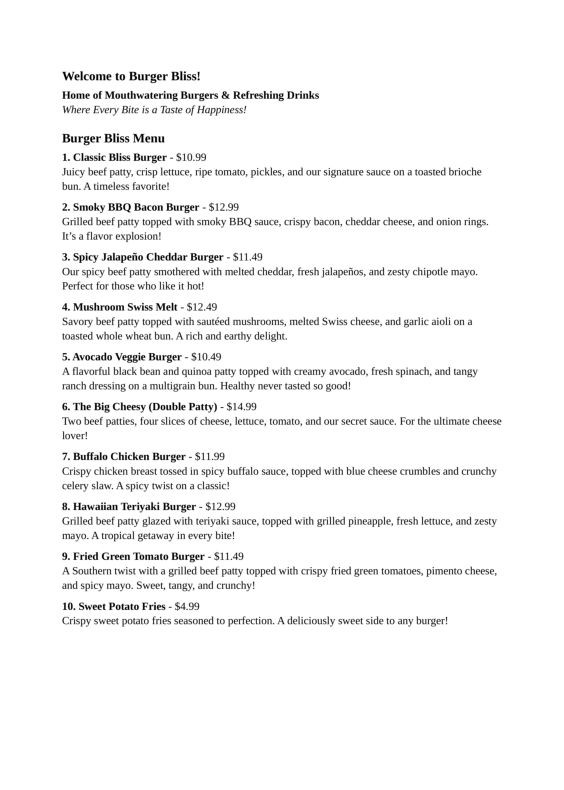

In [4]:
import fitz
import numpy as np
# Open PDF and load target page
pdf_path = f"{root_project_path}/burger_bliss.pdf" # requires PDF to be downloaded
doc = fitz.open(pdf_path)
page = doc.load_page(0) # number of page (our doc starts page numbers on page 41)

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image
#img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.axis('off') # Turn off axis
plt.show()

Process and visualize the text extracted from the first page

In [5]:
from tqdm.auto import tqdm # for progress bars, requires !pip install tqdm

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", "[SEP]").strip()

    return cleaned_text

# Open PDF and get lines/pages
# Note: this only focuses on text, rather than images/figures etc
def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """
    Opens a PDF file, reads its text content page by page, and collects statistics.

    Parameters:
        pdf_path (str): The file path to the PDF document to be opened and read.

    Returns:
        list[dict]: A list of dictionaries, each containing the page number
        (adjusted), character count, word count, sentence count, token count, and the extracted text
        for each page.
    """
    doc = fitz.open(pdf_path)  # open a document
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):  # iterate the document pages
        raw_text = page.get_text()  # get plain text encoded as UTF-8
        text = text_formatter(raw_text)
        pages_and_texts.append({"page_number": page_number,
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,  # 1 token = ~4 chars, see: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
                                "text": text,
                                "raw_text": raw_text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[0]

0it [00:00, ?it/s]

{'page_number': 0,
 'page_char_count': 1938,
 'page_word_count': 273,
 'page_sentence_count_raw': 21,
 'page_token_count': 484.5,
 'text': 'Welcome to Burger Bliss![SEP]Home of Mouthwatering Burgers & Refreshing Drinks[SEP]Where Every Bite is a Taste of Happiness![SEP]Burger Bliss Menu[SEP]1. Classic Bliss Burger - $10.99[SEP]Juicy beef patty, crisp lettuce, ripe tomato, pickles, and our signature sauce on a toasted brioche [SEP]bun. A timeless favorite![SEP]2. Smoky BBQ Bacon Burger - $12.99[SEP]Grilled beef patty topped with smoky BBQ sauce, crispy bacon, cheddar cheese, and onion rings. [SEP]It’s a flavor explosion![SEP]3. Spicy Jalapeño Cheddar Burger - $11.49[SEP]Our spicy beef patty smothered with melted cheddar, fresh jalapeños, and zesty chipotle mayo. [SEP]Perfect for those who like it hot![SEP]4. Mushroom Swiss Melt - $12.49[SEP]Savory beef patty topped with sautéed mushrooms, melted Swiss cheese, and garlic aioli on a [SEP]toasted whole wheat bun. A rich and earthy delight.[

To ensure a cleaner output from the RAG system, we'll split the text by dishes and drinks instead of by sentences. This way, we guarantee that each chunk contains a full, cohesive context rather than mixing parts of different dishes or drinks. By chunking the text this way, we ensure that the descriptions and prices for each dish or drink are intact and easy for the RAG system to work with.

Now lets process each dish separately

In [6]:
import re
import pandas as pd
def process_by_dish(pages_and_texts):
  # Regex pattern to get each dish separately
  pattern = r'(\d+)\.\s(.*?)(?=\n\d+\.|$)'

  for page in pages_and_texts:
    # Find all matches
    dishes = re.findall(pattern, page["raw_text"], re.DOTALL)
    sentences = [f"{i[0]}: {i[1]}" for i in dishes]
    sentences = [i.replace("\n", " ") for i in sentences]
    page["sentences"] = sentences
  return pages_and_texts

pages_and_texts = process_by_dish(pages_and_texts)

In [7]:
df = pd.DataFrame(pages_and_texts)
dish_df = df.explode('sentences')

# Extra processing in the dish_df
last_dish = dish_df.iloc[-1]["sentences"].split("Enjoy your drinks and burger experience at Burger Bliss!")[0]
extra_menu = dish_df.iloc[-1]["sentences"].split("Enjoy your drinks and burger experience at Burger Bliss!")[1]
dish_df.iloc[-1, dish_df.columns.get_loc('sentences')] = last_dish

extra_menu = extra_menu.split("•")[1:]
extra_menu[-1] =  "Guacamole - $1.50"
extra_menu_df = pd.DataFrame({"sentences":extra_menu, "page_number": [1 for i in extra_menu]})
dish_df = pd.concat([dish_df, extra_menu_df])
dish_df = dish_df[["sentences", "page_number"]]




### 2. **Generate a Small Fine-Tune Test Set**

We begin by importing our Local Language Model (LLM) to generate a custom dataset. While tools like ChatGPT or similar services could be used to build a dataset for us, this notebook aims to explore the entire process of dataset creation. Our goal is to demonstrate how information from a restaurant menu can be transformed into a fine-tuning dataset, enabling our model to acquire specific knowledge about our mock restaurant, Burger Bliss.

By the end of the finetuning process, the fine-tuned model will possess a detailed understanding of the menu, enhancing its ability to interact intelligently with customers.

We will explore the LLMs from Google, specifically focusing on [Gemma](https://huggingface.co/blog/gemma).

For our purposes, we will utilize the `gemma-2B`, which is a lightweight model developed by Google.

The table below outlines the GPU memory requirements for different versions of the Gemma LLMs, along with varying levels of precision.

| Model             | Precision | Min Memory (Bytes) | Min Memory (MB) | Min Memory (GB) | Recommended Memory (GB) | Hugging Face ID |
|-------------------|-----------|--------------------|------------------|------------------|-------------------------|------------------|
| [Gemma 2B](https://huggingface.co/google/gemma-2b-it)          | 4-bit     | 2,106,749,952      | 2009.15          | 1.96             | ~5.0                    | [`gemma-2b`](https://huggingface.co/google/gemma-2b) or [`gemma-2b-it`](https://huggingface.co/google/gemma-2b-it) for the instruction-tuned version |
| Gemma 2B          | Float16   | 5,079,453,696      | 4844.14          | 4.73             | ~8.0                    | Same as above      |
| [Gemma 7B](https://huggingface.co/google/gemma-7b-it)          | 4-bit     | 5,515,859,968      | 5260.33          | 5.14             | ~8.0                    | [`gemma-7b`](https://huggingface.co/google/gemma-7b) or [`gemma-7b-it`](https://huggingface.co/google/gemma-7b-it) for the instruction-tuned version |
| Gemma 7B          | Float16   | 17,142,470,656     | 16348.33         | 15.97            | ~19                     | Same as above      |

### Loading an LLM Locally

We will use `gemma-7b-it` (suitable for RTX 4090; adjust `model_id` and `use_quantization_config` as needed). For guidance, refer to the `gemma-7b-it` [Hugging Face model card](https://huggingface.co/google/gemma-7b-it) and utilize the [`transformers`](https://huggingface.co/docs/transformers/) library.

To load our LLM, we need:

1. **Quantization Config (optional)**: Use [`transformers.BitsAndBytesConfig`](https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/quantization#transformers.BitsAndBytesConfig) for 4-bit precision (requires [`bitsandbytes` library](https://github.com/TimDettmers/bitsandbytes)).
2. **Model ID**: Reference ID (e.g., `gemma-7b-it`) for the tokenizer and model.
3. **Tokenizer**: Convert raw text into tokens using [`transformers.AutoTokenizer.from_pretrained`](https://huggingface.co/docs/transformers/v4.38.2/en/model_doc/auto#transformers.AutoTokenizer).
4. **LLM Model**: Load the model with [`transformers.AutoModelForCausalLM.from_pretrained`](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForCausalLM.from_pretrained).

We will also check for [Flash Attention 2](https://huggingface.co/docs/transformers/perf_infer_gpu_one#flashattention-2) availability to enhance model performance.

In [8]:
from google.colab import userdata
hf_key = userdata.get("HF_TOKEN")

In [9]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

# 1. Create quantization config for smaller model loading (optional)
# Requires !pip install bitsandbytes accelerate, see: https://github.com/TimDettmers/bitsandbytes, https://huggingface.co/docs/accelerate/
# For models that require 4-bit quantization (use this if you have low GPU memory available)
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

# Bonus: Setup Flash Attention 2 for faster inference, default to "sdpa" or "scaled dot product attention" if it's not available
# Flash Attention 2 requires NVIDIA GPU compute capability of 8.0 or above, see: https://developer.nvidia.com/cuda-gpus
# Requires !pip install flash-attn, see: https://github.com/Dao-AILab/flash-attention
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")

# 2. Pick a model we'd like to use (this will depend on how much GPU memory you have available)
model_id = "google/gemma-2b-it"
print(f"[INFO] Using model_id: {model_id}")

# 3. Instantiate tokenizer (tokenizer turns text into numbers ready for the model)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id, token=hf_key)

# 4. Instantiate the model
use_cashed = False
if use_cashed:
  llm_model = AutoModelForCausalLM.from_pretrained("/content/drive/MyDrive/LLM/gemma_2b_vanilla")
else:
  llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                  torch_dtype=torch.float16, # datatype to use, we want float16
                                                  low_cpu_mem_usage=False, # use full memory
                                                  attn_implementation=attn_implementation,
                                                  token=hf_key) # which attention version to use
llm_model.to("cuda")

[INFO] Using attention implementation: sdpa
[INFO] Using model_id: google/gemma-2b-it


`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): GemmaRMSNorm((2048,), eps=1e-

In [10]:
save_ckpt = False
if save_ckpt:
  llm_model.save_pretrained("/content/drive/MyDrive/LLM/gemma_2b_vanilla", from_pt=True)

We've got an LLM!

Let's check it out.

In [11]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)/ 1e9

2.506172416

It, turns out that Gemma 2B is really Gemma 2.5B.

In [12]:
def get_model_mem_size(model: torch.nn.Module):
    """
    Get how much memory a PyTorch model takes up.

    See: https://discuss.pytorch.org/t/gpu-memory-that-model-uses/56822
    """
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 5012354048, 'model_mem_mb': 4780.15, 'model_mem_gb': 4.67}

It appears that this model occupies approximately 5.1GB of GPU memory, with additional space required for the forward pass due to the computations occurring between layers. Therefore, I rounded it up to around 8GB in the table above.

Now, let's move on to the exciting part: generating some text!

### Generating Text with Our LLM
Before the actual finetune process lets try a query that requires information of the burger bliss menu.

In [13]:
input_text = "What is the hamburguer options in the menu?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
What is the hamburguer options in the menu?

Prompt (formatted):
<bos><start_of_turn>user
What is the hamburguer options in the menu?<end_of_turn>
<start_of_turn>model



In [14]:
%%time

# Tokenize the input text (turn it into numbers) and send it to GPU
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
print(f"Model input (tokenized):\n{input_ids}\n")

# Generate outputs passed on the tokenized input
# See generate docs: https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256) # define the maximum number of new tokens to create
print(f"Model output (tokens):\n{outputs[0]}\n")

Model input (tokenized):
{'input_ids': tensor([[     2,      2,    106,   1645,    108,   1841,    603,    573,  37630,
            525,  44685,   4561,    575,    573,   6901, 235336,    107,    108,
            106,   2516,    108]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}



Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   1841,    603,    573,  37630,
           525,  44685,   4561,    575,    573,   6901, 235336,    107,    108,
           106,   2516,    108, 235285,   1144,  14321,    577,   3684,   1879,
        235290,   1602,   2113, 235269,   5852,    590,   2952,   3658,    476,
          6901,    696,    736,   1069, 235265,   1699,    573,   1546,    908,
        235290,    511, 235290,   1545,   4561,    578,  31017,    576,    573,
        210499,   9336, 235269,   3743,   2701,    573,   6901,    611,    573,
          9208, 235303, 235256,   4451,    689,   3127,   4562,   7297, 235265,
             1], device='cuda:0')

CPU times: user 2.19 s, sys: 124 ms, total: 2.31 s
Wall time: 2.81 s


In [15]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
What is the hamburguer options in the menu?<end_of_turn>
<start_of_turn>model
I am unable to access real-time information, therefore I cannot provide a menu at this time. For the most up-to-date options and descriptions of the hamburgers offered, please check the menu on the restaurant's website or social media pages.<eos>



As expected the LLM does not have context to awnser correctly.

> **Note:** `"<bos>"` and `"<eos>"` are special tokens to denote "beginning of sentence" and "end of sentence" respectively.

In [16]:
print(f"Input text: {input_text}\n")
print(f"Output text:\n{outputs_decoded.replace(prompt, '').replace('<bos>', '').replace('<eos>', '')}")

Input text: What is the hamburguer options in the menu?

Output text:
I am unable to access real-time information, therefore I cannot provide a menu at this time. For the most up-to-date options and descriptions of the hamburgers offered, please check the menu on the restaurant's website or social media pages.


We've successfully generated text from an LLM running locally, covering the Retrieval (R) and Generation (G) components of RAG. Now, let’s explore the final step: Augmentation.

To begin, let's compile a list of queries to test our pipeline

### Create a Prompt Formatter
In this step, we will develop a custom prompt formatter designed specifically to generate instruction-style queries and responses. This formatter will be used to create the structured data necessary for fine-tuning our model, ensuring that the generated prompts are tailored to the context of our restaurant scenario.

In [17]:
def prompt_formatter(context: str) -> str:
    """
    Augments query with text-based context from context_items.
    """
    # Join context items into one dotted paragraph

    # Create a base prompt with examples to help the model
    # Note: this is very customizable, I've chosen to use 3 examples of the answer style we'd like.
    # We could also write this in a txt file and import it in if we wanted.
    base_prompt = """Based on the following menu dishes in the user query, create a query in a instruction based format example
Always use the information in the context to create the query and the model response.
Use the following examples as reference for the ideal answer style.
\nExample 1
Base dish: 1. Classic Bliss Burger - $10.99 Juicy beef patty, crisp lettuce, ripe tomato, pickles, and our signature sauce on a toasted brioche bun. A timeless favorite!
**Query:**: What's in the Classic Bliss Burger?
**Answer:**: The Classic Bliss Burger features a juicy beef patty, crisp lettuce, ripe tomato, pickles, and our signature sauce, all on a toasted brioche bun. It costs $10.99.
\nExample 2:
Base dish: 4. Mushroom Swiss Melt - $12.49 Savory beef patty topped with sautéed mushrooms, melted Swiss cheese, and garlic aioli on a toasted whole wheat bun. A rich and earthy delight.
**Query**: Does the Mushroom Swiss Melt come with a side?
**Answer**: The Mushroom Swiss Melt does not come with a side, but you can add fries or a salad to your order for an additional charge.
\nExample 3:
Base dish: 3. Fresh Lemonade - $2.99 Homemade and refreshing, made with real lemons and just the right amount of sweetness.
**Query**: Can you tell me more about the Fresh Lemonade?
**Answer**: The Fresh Lemonade is a homemade, refreshing drink made with real lemons and balanced sweetness. It’s priced at $2.99.
Base dish: 3. Fresh Lemonade - $2.99 Homemade and refreshing, made with real lemons and just the right amount of sweetness.
**Query:**: What’s in the Fresh Lemonade? And how much it costs?
**Answer:**:Model response: The Fresh Lemonade is homemade and refreshing, made with real lemons and just the right amount of sweetness. It costs $2.99.
Now based on the following base dish, create a instruction based format example of query and model response
Base dish: {context}
Answer:"""

    # Update base prompt with context items and query
    base_prompt = base_prompt.format(context=context)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

Looking good! Let's try our function out.

In [18]:
# Format prompt with context items
prompt = prompt_formatter(context=dish_df.iloc[0]["sentences"])
print(prompt)

<bos><start_of_turn>user
Based on the following menu dishes in the user query, create a query in a instruction based format example
Always use the information in the context to create the query and the model response.
Use the following examples as reference for the ideal answer style.

Example 1
Base dish: 1. Classic Bliss Burger - $10.99 Juicy beef patty, crisp lettuce, ripe tomato, pickles, and our signature sauce on a toasted brioche bun. A timeless favorite!
**Query:**: What's in the Classic Bliss Burger?
**Answer:**: The Classic Bliss Burger features a juicy beef patty, crisp lettuce, ripe tomato, pickles, and our signature sauce, all on a toasted brioche bun. It costs $10.99.

Example 2:
Base dish: 4. Mushroom Swiss Melt - $12.49 Savory beef patty topped with sautéed mushrooms, melted Swiss cheese, and garlic aioli on a toasted whole wheat bun. A rich and earthy delight.
**Query**: Does the Mushroom Swiss Melt come with a side?
**Answer**: The Mushroom Swiss Melt does not come wi

Now, let's instantiate the `ask` function, which will serve as our primary method for sending queries to the model and retrieving its responses. This function will utilize the prompt formatter, along with parameters like temperature and other arguments, to fine-tune how the model generates its answers.

In [42]:
def ask(context,
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=False,
        return_answer_only=True,
        llm_model=llm_model,
        prompt_formatter=prompt_formatter):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """

    # Format the prompt with context items
    prompt = prompt_formatter(context)

    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)

    # Turn the output tokens into text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        # Replace special tokens and unnecessary help message
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    # Only return the answer without the context items
    if return_answer_only:
        return output_text

    return output_text

Testing the instruction based prompt formater

In [20]:
query = dish_df.iloc[7]["sentences"] #random.choice(query_list)
print(f"Query: {query}")

# Answer query with context and return context
answer  = ask(query,
              temperature=0.9,
              max_new_tokens=512,
              return_answer_only=False)

print(f"Answer:\n")
print(answer)

Query: 8: Hawaiian Teriyaki Burger - $12.99 Grilled beef patty glazed with teriyaki sauce, topped with grilled pineapple, fresh lettuce, and zesty  mayo. A tropical getaway in every bite!
Answer:

<bos><bos><start_of_turn>user
Based on the following menu dishes in the user query, create a query in a instruction based format example
Always use the information in the context to create the query and the model response.
Use the following examples as reference for the ideal answer style.

Example 1
Base dish: 1. Classic Bliss Burger - $10.99 Juicy beef patty, crisp lettuce, ripe tomato, pickles, and our signature sauce on a toasted brioche bun. A timeless favorite!
**Query:**: What's in the Classic Bliss Burger?
**Answer:**: The Classic Bliss Burger features a juicy beef patty, crisp lettuce, ripe tomato, pickles, and our signature sauce, all on a toasted brioche bun. It costs $10.99.

Example 2:
Base dish: 4. Mushroom Swiss Melt - $12.49 Savory beef patty topped with sautéed mushrooms, mel


### **Generate Queries and Responses**

Next, we’ll create the processing functions necessary for breaking down the model’s responses into usable components. Additionally, we’ll develop a helper function to streamline the query generation process, ensuring that our data is well-structured and ready for fine-tuning.

In [21]:
def generate_dataset_data_point(answer):
  split_point_1 = "Now based on the following base dish, create a instruction based format example of query and model response"
  split_point_2 = "\n"

  # Split the awnser and return the context, input and output
  answer = answer.split(split_point_1)[1]
  answer = answer.split(split_point_2)
  context = answer[1]
  # print(answer)
  try:
    input  = " ".join(answer[4].split(" ")[1:])
    output = " ".join(answer[5].split(" ")[1:])
    if "**" in output:
      output = output.split("**")[1].replace(":", "")
  except:
    input  = np.nan
    output = np.nan

  return context, input, output

In [22]:
def generate_dataset(query: str, temperature: float):
  # Answer query with context and return context
  answer  = ask(query,
                temperature=0.9,
                max_new_tokens=512,
                return_answer_only=False)

  return answer

##Generate the Dataset
In this step, we will set a range of temperature values to influence the model’s creativity and variability in generating questions for each dish on the menu. The temperature parameter controls the randomness of the model's responses: a lower temperature (e.g., 0.2) leads to more deterministic and focused outputs, while a higher temperature (e.g., 0.8) encourages more diverse and creative responses. By systematically generating questions at various temperature settings, we aim to compile a small dataset that captures different interpretations of the prompts and the formatter itself.

At the conclusion of this process, we will have structured data comprising three key components: context (the specific dish used to create the query and response), input (the query itself), and output (the model's response based on the query). This diverse dataset will enhance the fine-tuning of our model, enabling it to understand and engage with customer inquiries more effectively.

In [23]:
from glob import glob
generate = False
if generate:
  for temp in [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]:
      dish_df["answer"] = dish_df["sentences"].apply(lambda x: generate_dataset(x, temp))
      dish_df.to_csv(f"{root_project_path}/dish_df_temp_{temp}.csv")
      dish_full_df = pd.concat([pd.read_csv(i) for i in glob(f"{root_project_path}/dish_df_temp_*")])
      dish_full_df = dish_full_df[["sentences", "answer"]]
      dish_full_df[["context", "input", "output"]] = dish_full_df.apply(lambda x: generate_dataset_data_point(x.answer), axis=1, result_type = "expand")
      dish_full_df = dish_full_df.drop_duplicates()
      dish_full_df[['context', 'input', 'output']].to_csv(f"{root_project_path}dish_df_full.csv", index=False)
else:
  dish_df = pd.read_csv(f"{root_project_path}/dish_df_full.csv")

##Further Processing of the Dataset
In this section, we will refine the dataset to prepare it for input into the LoRA trainer. This involves structuring the data to meet the training algorithm's requirements, enhancing its quality and consistency for a more efficient fine-tuning process.

In [24]:
from datasets import Dataset, load_dataset
dataset = load_dataset("csv", data_files=f"{root_project_path}dish_df_full.csv")

In [25]:
def generate_prompt(data_point):
    prefix_text = 'Depending on the following prompt, the response should be like this.\\n\\n'
    # Samples with additional context into.
    input = data_point['input']
    output = data_point['output']
    text = f"""<start_of_turn>user {prefix_text} {input}  <end_of_turn>\\n<start_of_turn>model{output} <end_of_turn>"""
    return text

# add the "prompt" column in the dataset
text_column = [generate_prompt(data_point) for data_point in dataset['train']]
dataset = dataset['train'].add_column("prompt_text", text_column)

In [26]:
dataset = dataset.map(lambda samples: tokenizer(samples["prompt_text"]), batched=True)

In [27]:
ds_train=dataset.shuffle(True).select(range(120))
ds_val=dataset.shuffle(True).select(range(120,147))

# 3. **Fine-Tune the Model LoRA Style**

First, we will establish the LoRA configuration that will guide our fine-tuning process. This includes setting various parameters such as QLoRA and BitsAndBytes configurations, along with specifying essential training arguments. Additionally, we will utilize the PeftModel to implement low-rank adapters (LoRA) through the `get_peft_model` utility function and the `prepare_model_for_kbit_training` method from the PEFT library. This setup will optimize our model for efficient and effective fine-tuning.

In [28]:
from peft import LoraConfig, get_peft_model
lora_config = LoraConfig(
    r=64,
    lora_alpha=32,
    target_modules=['o_proj', 'q_proj', 'up_proj', 'v_proj', 'k_proj', 'down_proj', 'gate_proj'],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
llm_model = get_peft_model(llm_model, lora_config)

In [29]:
trainable, total = llm_model.get_nb_trainable_parameters()
print(f"Trainable: {trainable} | total: {total} | Percentage: {trainable/total*100:.4f}%")

Trainable: 78446592 | total: 2584619008 | Percentage: 3.0351%


### **Instantiate the SFTTrainer**

Next, we will utilize the **SFTTrainer** from the **trl** library to facilitate supervised fine-tuning of our model. This trainer is designed to streamline the fine-tuning process, allowing us to effectively implement the training strategies we’ve configured.


In [30]:
import transformers

from trl import SFTTrainer

tokenizer.pad_token = tokenizer.eos_token
torch.cuda.empty_cache()
trainer = SFTTrainer(
    model=llm_model,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    dataset_text_field="prompt_text",
    peft_config=lora_config,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        warmup_steps=3,
        max_steps=20,
        learning_rate=2e-4,
        logging_steps=1,
        eval_strategy="steps",
        output_dir="outputs",
        optim="paged_adamw_8bit",
        save_strategy="epoch",
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:292: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:321: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:396: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overf

### Begin the finetune!

In [31]:
# Start the training process
trainer.train()



Step,Training Loss,Validation Loss
1,7.017300,7.456842
2,7.089200,6.653327
3,6.769100,5.552900
4,5.830500,4.457561
5,4.003000,3.826080
6,3.225800,3.342277
7,3.179400,2.931893
8,2.532200,2.590885
9,2.087100,2.406829
10,2.144700,2.289011


TrainOutput(global_step=20, training_loss=3.1235557794570923, metrics={'train_runtime': 52.8115, 'train_samples_per_second': 1.515, 'train_steps_per_second': 0.379, 'total_flos': 62514563444736.0, 'train_loss': 3.1235557794570923, 'epoch': 0.6666666666666666})


## **Save the Fine-Tuned Weights for Later Use**

After the fine-tuning process is complete, we will save the fine-tuned model weights for future use. Storing these weights allows us to easily reload the optimized model for subsequent inference tasks or further training, ensuring that we retain the improvements made during this fine-tuning phase.

In [33]:
new_model = "/content/drive/MyDrive/LLM/gemma-resturant-finetune-test" #Name of the model you will be pushing to huggingface model hub
# Save the fine-tuned model
trainer.model.save_pretrained(new_model)

# 4. **Test the Model**

First, we will merge the trained weights with the base model to create the final version of our model. Next, we will conduct a simple test using the same query that the model previously struggled with: **"What are the hamburger options on the menu?"** This will help us evaluate the effectiveness of our fine-tuning efforts and determine if the model has improved in handling specific customer inquiries.

In [34]:
from peft import LoraConfig, PeftModel

# Merge the model with LoRA weights
base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map={"": 0},
)
merged_model= PeftModel.from_pretrained(base_model, new_model)
merged_model= merged_model.merge_and_unload()

# Save the merged model
merged_model.save_pretrained("merged_model",safe_serialization=True)
tokenizer.save_pretrained("merged_model")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Create Another Prompt Formatter for Testing
Our previous prompt formatter was designed to create instruction-based datasets by leveraging the Gemma model. Now, we will develop a new prompt formatter tailored for testing purposes. This formatter will simulate interactions as if the model were an employee of Burger Bliss, allowing us to assess its ability to respond to customer inquiries in a more realistic and conversational manner.

In [40]:
def prompt_formatter_test(query: str) -> str:
    """
    Augments query with text-based context from context_items.
    """
    # Join context items into one dotted paragraph

    # Create a base prompt with examples to help the model
    # Note: this is very customizable, I've chosen to use 3 examples of the answer style we'd like.
    # We could also write this in a txt file and import it in if we wanted.
    base_prompt = """Based on your knowledge of burger bliss menu, please answer the query. Consider that you is the waiter of the resturant, allways awnser the query thinking you work as waiter in burger bliss.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query:Hi! Do you have any vegetarian options on the menu?
Answer:Absolutely! We have our Avocado Veggie Burger, which is made with a black bean and quinoa patty! Would you like to try that?
\nExample 2:
Query:What’s the difference between the Classic Bliss Burger and the Big Cheesy?
Answer:The Classic Bliss Burger features a single beef patty with fresh lettuce, tomato, and our signature sauce. The Big Cheesy has two beef patties and four slices of cheese for an extra indulgent experience. Both are fantastic, but it depends on how hungry you are!
\nExample 3:
Query:Hi there! I’d like to order a Fried Green Tomato Burger and a lemonade, please.
Answer:Great choice! Your subtotal comes to $11.49 for the Fried Green Tomato Burger and $2.99 for the lemonade, which totals $14.48. Would you like anything else with that?
Now based on the following base dish, create a instruction based format example of query and model response
User query: {query}
Answer:"""

    # Update base prompt with context items and query
    base_prompt = base_prompt.format(query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

In [49]:
# Answer query with context and return context
answer  = ask("What is the hamburguer options in the menu?",
              temperature=0.8,
              max_new_tokens=512,
              return_answer_only=False,
              llm_model=merged_model,
              prompt_formatter=prompt_formatter_test)

print(f"Answer:\n")
print(answer)

Answer:

<bos><bos><start_of_turn>user
Based on your knowledge of burger bliss menu, please answer the query. Consider that you is the waiter of the resturant, allways awnser the query thinking you work as waiter in burger bliss.
Use the following examples as reference for the ideal answer style.

Example 1:
Query:Hi! Do you have any vegetarian options on the menu?
Answer:Absolutely! We have our Avocado Veggie Burger, which is made with a black bean and quinoa patty! Would you like to try that?

Example 2:
Query:What’s the difference between the Classic Bliss Burger and the Big Cheesy?
Answer:The Classic Bliss Burger features a single beef patty with fresh lettuce, tomato, and our signature sauce. The Big Cheesy has two beef patties and four slices of cheese for an extra indulgent experience. Both are fantastic, but it depends on how hungry you are!

Example 3:
Query:Hi there! I’d like to order a Fried Green Tomato Burger and a lemonade, please.
Answer:Great choice! Your subtotal comes

Finally, it appears that the model has successfully learned the Burger Bliss menu! Next, we will combine our fine-tuned model with Retrieval-Augmented Generation (RAG) to evaluate the robustness of a complete pipeline for this restaurant use case. This integration will allow us to assess how well the model can provide accurate and contextually relevant responses while leveraging both the internal knowledge gained from fine-tuning and the external information accessed through RAG.